# Runnable Tutorial: Solver Comparison and Timing

**Note**: This notebook should be run from the repository root with proper imports configured.

# Runnable Tutorial: timing and comparison of solvers (Direct, CG, Jacobi, ADI)

This notebook runs benchmarks across multiple grid sizes, records timings for Direct, CG, Jacobi and ADI (Alternating Direction Implicit / line-relaxation), saves figures into `02-Elliptic-Equations/figures/`, and writes a CSV with the timing table.
Ensure `02-Elliptic-Equations/requirements.txt` is installed in your environment (numpy, scipy, matplotlib, pandas).

In [1]:
# Setup paths for imports
import sys
from pathlib import Path

# Get repository root (notebook is in 02-Elliptic-Equations/notebooks/)
repo_root = Path.cwd()
if 'notebooks' in str(Path.cwd()):
    repo_root = Path.cwd().parent.parent
    
sys.path.insert(0, str(repo_root / '02-Elliptic-Equations' / 'src'))
sys.path.insert(0, str(repo_root / '01-Linear-Systems' / 'src'))

In [2]:
import sys
from pathlib import Path

# Find repo root by going up from notebook location
notebook_dir = Path.cwd()
repo_root = notebook_dir
for _ in range(10):
    if (repo_root / '02-Elliptic-Equations').exists():
        break
    if repo_root.parent == repo_root:
        # Reached filesystem root, use cwd
        repo_root = Path('/workspaces/Computational-Physics-Numerical-methods')
        break
    repo_root = repo_root.parent

src_path = repo_root / '02-Elliptic-Equations' / 'src'
if src_path.exists():
    sys.path.insert(0, str(src_path))
    print(f'✓ Added to sys.path: {src_path}')
else:
    print(f'⚠ Warning: {src_path} not found, trying relative path')
    sys.path.insert(0, '../src')

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from elliptic import build_poisson_2d, solve_direct, solve_cg, jacobi, adi_solve, line_relaxation

outdir = Path('02-Elliptic-Equations/figures')
outdir.mkdir(parents=True, exist_ok=True)
print(f'✓ Output directory: {outdir.resolve()}')

⚠ Warning: /workspaces/Computational-Physics-Numerical-methods/02-Elliptic-Equations/notebooks/02-Elliptic-Equations/src not found, trying relative path
✓ Output directory: /workspaces/Computational-Physics-Numerical-methods/02-Elliptic-Equations/notebooks/02-Elliptic-Equations/figures


## Benchmark configuration
We test a small set of grids so the notebook runs in a few seconds locally. Increase sizes for heavier experiments.

In [3]:
sizes = [(40,30), (80,60), (120,90)]  # (nx, ny) including boundaries
results = []
for nx, ny in sizes:
    print(f'Running grid: nx={nx}, ny={ny}')
    bc = {'left': ('dirichlet', 0.0), 'right': ('dirichlet', 0.0),
          'bottom': ('dirichlet', 0.0), 'top': ('dirichlet', 100.0)}
    A, b, meta = build_poisson_2d(nx, ny, lx=2.0, ly=1.0, bc=bc)
    nx_tot, ny_tot, hx, hy = meta
    
    # Interior points
    nx_i = nx_tot - 2
    ny_i = ny_tot - 2

    # Direct
    t0 = time.perf_counter()
    x_direct = solve_direct(A, b)
    t_direct = time.perf_counter() - t0

    # CG
    t0 = time.perf_counter()
    x_cg, info = solve_cg(A, b, tol=1e-8, precondition='jacobi')
    t_cg = time.perf_counter() - t0

    # Jacobi (coarse tolerance)
    t0 = time.perf_counter()
    x_j, it_j, r_j = jacobi(A, b, tol=1e-6, maxiter=2000)
    t_j = time.perf_counter() - t0

    # ADI: uses interior points (nx_i, ny_i)
    t0 = time.perf_counter()
    x_adi, it_adi, res_adi = adi_solve(nx_i, ny_i, hx, hy, bc, b, tol=1e-6, maxiter=100)
    t_adi = time.perf_counter() - t0

    results.append({
        'nx': nx, 'ny': ny, 'n_unknowns': A.shape[0], 
        'time_direct': t_direct, 
        'time_cg': t_cg, 'cg_info': info, 
        'time_jacobi': t_j, 'jacobi_iters': it_j, 
        'time_adi': t_adi, 'adi_iters': it_adi
    })

    # Save direct solution figure
    U = np.zeros((ny_tot, nx_tot))
    k = 0
    for i in range(nx_i):
        for j in range(ny_i):
            U[j+1, i+1] = x_direct[k]
            k += 1
    U[0, :] = bc['bottom'][1]
    U[-1, :] = bc['top'][1]
    U[:, 0] = bc['left'][1]
    U[:, -1] = bc['right'][1]
    
    fig, ax = plt.subplots(figsize=(6,3))
    im = ax.imshow(U, origin='lower', cmap='coolwarm', extent=[0,2.0,0,1.0])
    ax.set_title(f'Direct solution nx={nx}, ny={ny}')
    fig.colorbar(im, ax=ax)
    figpath = outdir / f'direct_nx{nx}_ny{ny}.png'
    fig.savefig(figpath, dpi=150, bbox_inches='tight')
    plt.close(fig)
    print(f'  ✓ Saved {figpath.name}')

# Save timing table and show
df = pd.DataFrame(results)
csvpath = outdir / 'timings_with_adi.csv'
df.to_csv(csvpath, index=False)
print(f'\n✓ Timings saved to {csvpath}')
print(f'\nTiming Results:')
df

Running grid: nx=40, ny=30
  ✓ Saved direct_nx40_ny30.png
Running grid: nx=80, ny=60
  ✓ Saved direct_nx80_ny60.png
Running grid: nx=120, ny=90
  ✓ Saved direct_nx120_ny90.png

✓ Timings saved to 02-Elliptic-Equations/figures/timings_with_adi.csv

Timing Results:


,nx,ny,n_unknowns,time_direct,time_cg,cg_info,time_jacobi,jacobi_iters,time_adi,adi_iters
0,40,30,1064,0.005287,0.003693,{'info': 0},0.059248,2000,0.316232,100
1,80,60,4524,0.011858,0.007100,{'info': 0},0.072771,2000,1.171925,100
2,120,90,10384,0.030040,0.027464,{'info': 0},0.181294,2000,2.513840,100


## Plots: scaling and comparison
Load the CSV with timings and plot scaling for Direct vs CG vs Jacobi vs ADI.

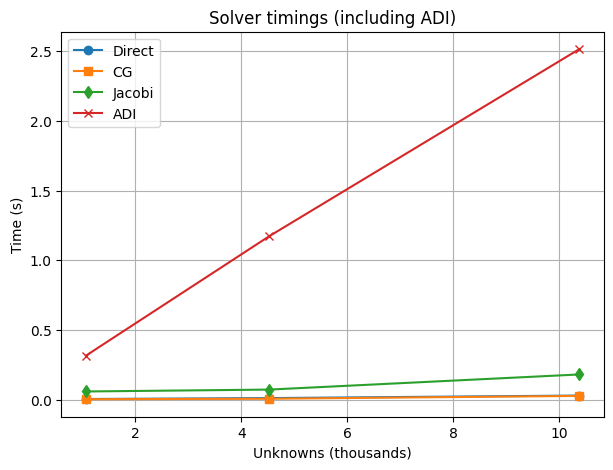

In [4]:
import pandas as pd
df = pd.read_csv(outdir / 'timings_with_adi.csv')
df['n_unknowns_k'] = df['n_unknowns'] / 1000.0
plt.figure(figsize=(7,5))
plt.plot(df['n_unknowns_k'], df['time_direct'], 'o-', label='Direct')
plt.plot(df['n_unknowns_k'], df['time_cg'], 's-', label='CG')
plt.plot(df['n_unknowns_k'], df['time_jacobi'], 'd-', label='Jacobi')
plt.plot(df['n_unknowns_k'], df['time_adi'], 'x-', label='ADI')
plt.xlabel('Unknowns (thousands)')
plt.ylabel('Time (s)')
plt.title('Solver timings (including ADI)')
plt.legend()
plt.grid(True)
plt.savefig(outdir / 'timing_scaling_with_adi.png', dpi=150, bbox_inches='tight')
plt.show()